
# Trabajo_TelecomX_2

## 1. Importar librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from joblib import dump


## 2. Cargar datos

In [ ]:
df = pd.read_csv("datos_n_f.csv")
df.shape, df.dtypes.head()

((7267, 23),
 customerID       object
 Churn              bool
 gender           object
 SeniorCitizen      bool
 Partner            bool
 dtype: object)


## 3. Preprocesamiento básico
- Renombrar columnas con puntos
- Mapear `Churn` a 0/1
- Eliminar identificadores (`customerID`, `ID_valido` , `Charges.Total_missing`)
- Convertir booleanos a 0/1


In [ ]:
df = df.rename(columns={
    "Charges.Monthly": "MonthlyCharges",
    "Charges.Total": "TotalCharges"
})

# Churn a 0/1
df["Churn"] = df["Churn"].astype(int)

# Eliminar columnas no predictoras
df = df.drop(columns=["customerID","ID_valido","Charges.Total_missing"], errors="ignore")

# Convertir booleanos a enteros
bool_cols = df.select_dtypes(include=["bool"]).columns
df[bool_cols] = df[bool_cols].astype(int)

df.head()

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,Female,0,1,1,9,1,0,DSL,No,Yes,No,Yes,Yes,No,One year,1,Mailed check,65.6,593.30
1,0,Male,0,0,0,9,1,1,DSL,No,No,No,No,No,Yes,Month-to-month,0,Mailed check,59.9,542.40
2,1,Male,0,0,0,4,1,0,Fiber optic,No,No,Yes,No,No,No,Month-to-month,1,Electronic check,73.9,280.85
3,1,Male,1,1,0,13,1,0,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,1,Electronic check,98.0,1237.85
4,1,Female,1,1,0,3,1,0,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,1,Mailed check,83.9,267.40



## 4. Exploración inicial (EDA)
### 4.1 Distribución de la variable objetivo

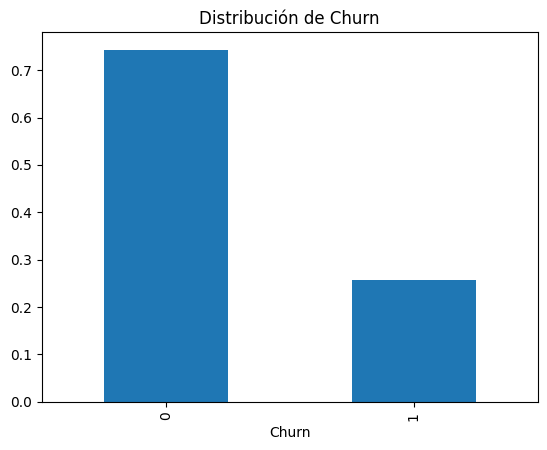

In [ ]:
df["Churn"].value_counts(normalize=True).plot(kind="bar", title="Distribución de Churn")
plt.show()


### 4.2 Correlaciones numéricas

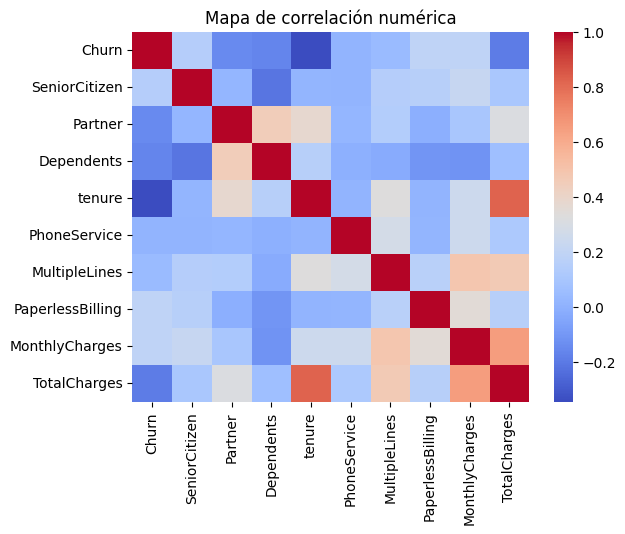

In [ ]:
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Mapa de correlación numérica")
plt.show()


### 4.3 Tasa de churn por categorías

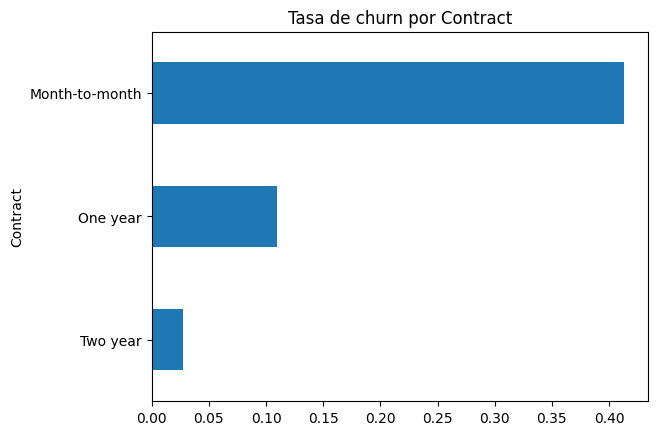

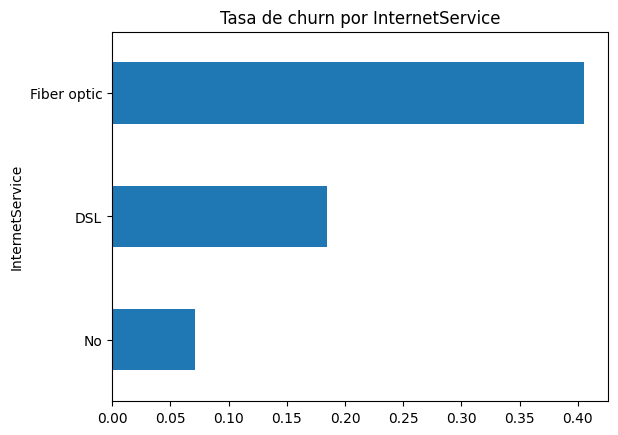

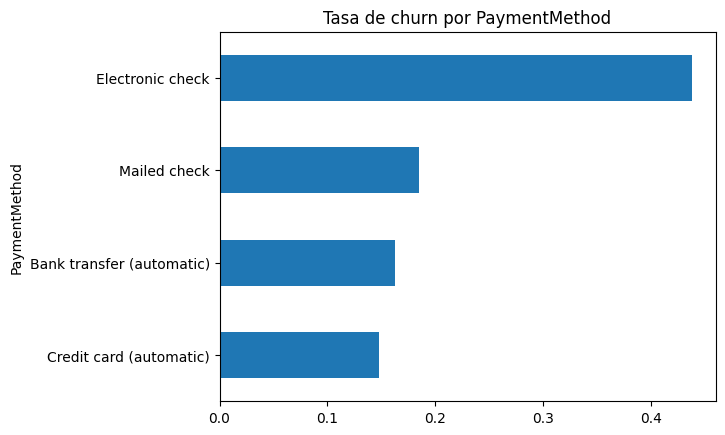

In [ ]:
for col in ["Contract", "InternetService", "PaymentMethod"]:
    tasa = df.groupby(col)["Churn"].mean().sort_values()
    tasa.plot(kind="barh", title=f"Tasa de churn por {col}")
    plt.show()


## 5. División de datos

In [ ]:
X = df.drop(columns=["Churn"])
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


## 6. Preprocesador

In [ ]:
num_cols = X_train.select_dtypes(include=["int64","float64"]).columns
cat_cols = X_train.select_dtypes(include=["object"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ]
)


## 7. Modelos y pipeline con SMOTE

In [ ]:
pipe_log = ImbPipeline([
    ("pre", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

pipe_rf = ImbPipeline([
    ("pre", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1))
])


## 8. GridSearch para Logistic Regression

In [ ]:
param_grid = {
    "clf__C": [0.05, 0.1, 0.5, 1, 2],
    "clf__solver": ["liblinear", "lbfgs"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs_log = GridSearchCV(pipe_log, param_grid, scoring="f1", cv=cv, n_jobs=-1, refit=True)
gs_log.fit(X_train, y_train)

print("Mejores parámetros:", gs_log.best_params_)

Mejores parámetros: {'clf__C': 0.05, 'clf__solver': 'liblinear'}



## 9. Entrenamiento Random Forest

In [ ]:
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService',
       'MultipleLines', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['gender', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaymentMethod'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('clf',
                 RandomForestClassifier(n_estimators=400, n_jobs=-1,
                                        random_state=42))])

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(gs_log.best_estimator_, X_train, y_train, cv=5, scoring="f1")
print("CV F1 scores:", cv_scores)
print("CV F1 mean:", cv_scores.mean())

CV F1 scores: [0.59346405 0.61699346 0.63368984 0.61878453 0.61082474]
CV F1 mean: 0.6147513257133688



## 10. Evaluación en test

In [ ]:
y_pred_log = gs_log.predict(X_test)
y_proba_log = gs_log.predict_proba(X_test)[:,1]

y_pred_rf = pipe_rf.predict(X_test)
y_proba_rf = pipe_rf.predict_proba(X_test)[:,1]

def evaluar(y_true,y_pred,y_proba):
    return {
        "Accuracy": accuracy_score(y_true,y_pred),
        "Precision": precision_score(y_true,y_pred),
        "Recall": recall_score(y_true,y_pred),
        "F1": f1_score(y_true,y_pred),
        "ROC-AUC": roc_auc_score(y_true,y_proba)
    }

res = pd.DataFrame([
    {"Modelo":"Logistic Regression", **evaluar(y_test,y_pred_log,y_proba_log)},
    {"Modelo":"Random Forest", **evaluar(y_test,y_pred_rf,y_proba_rf)}
])
res

,Modelo,Accuracy,Precision,Recall,F1,ROC-AUC
0,Logistic Regression,0.753783,0.513746,0.799465,0.625523,0.843871
1,Random Forest,0.773728,0.562327,0.542781,0.552381,0.817953


In [ ]:
print("Reporte de clasificación - Logistic Regression")
print(classification_report(y_test, y_pred_log))

print("Reporte de clasificación - Random Forest")
print(classification_report(y_test, y_pred_rf))

Reporte de clasificación - Logistic Regression
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1080
           1       0.51      0.80      0.63       374

    accuracy                           0.75      1454
   macro avg       0.71      0.77      0.72      1454
weighted avg       0.81      0.75      0.77      1454

Reporte de clasificación - Random Forest
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1080
           1       0.56      0.54      0.55       374

    accuracy                           0.77      1454
   macro avg       0.70      0.70      0.70      1454
weighted avg       0.77      0.77      0.77      1454




## 11. Gráficos de performance
### 11.1 Matriz de confusión

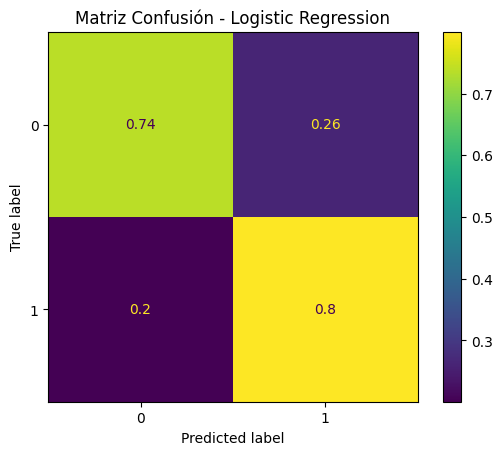

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_log,normalize="true")
plt.title("Matriz Confusión - Logistic Regression")
plt.show()


### 11.2 ROC y PR

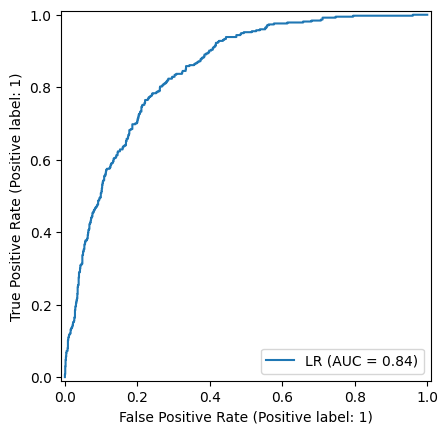

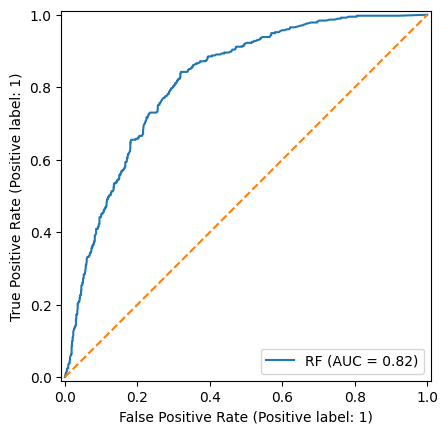

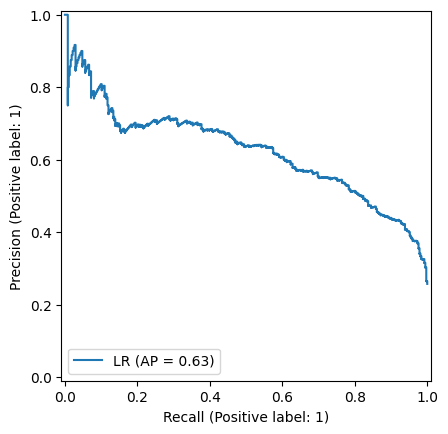

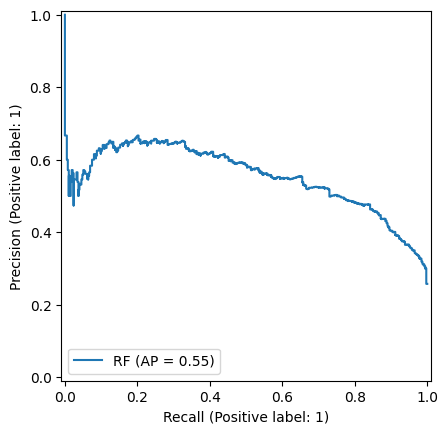

In [ ]:
RocCurveDisplay.from_predictions(y_test,y_proba_log,name="LR")
RocCurveDisplay.from_predictions(y_test,y_proba_rf,name="RF")
plt.plot([0,1],[0,1],"--")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test,y_proba_log,name="LR")
PrecisionRecallDisplay.from_predictions(y_test,y_proba_rf,name="RF")
plt.show()

In [ ]:
from sklearn.metrics import average_precision_score

print("Average Precision (LR):", average_precision_score(y_test, y_proba_log))
print("Average Precision (RF):", average_precision_score(y_test, y_proba_rf))

Average Precision (LR): 0.6250238149473442
Average Precision (RF): 0.5520685978727271



### 11.3 Curva de ganancias

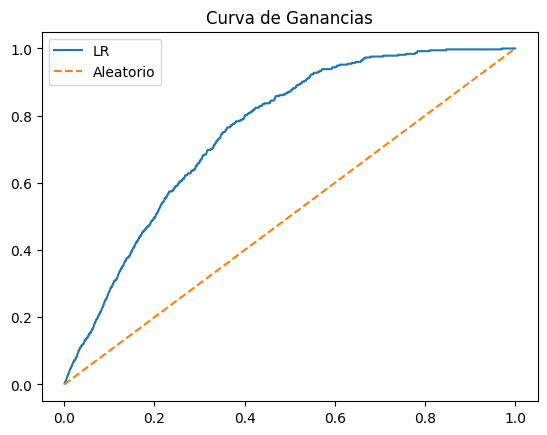

In [ ]:
df_aux = pd.DataFrame({"y":y_test,"p":y_proba_log}).sort_values("p",ascending=False)
df_aux["cum_pos"] = df_aux["y"].cumsum()
df_aux["perc_customers"] = np.arange(1,len(df_aux)+1)/len(df_aux)
df_aux["perc_positives"] = df_aux["cum_pos"]/df_aux["y"].sum()

plt.plot(df_aux["perc_customers"],df_aux["perc_positives"],label="LR")
plt.plot([0,1],[0,1],"--",label="Aleatorio")
plt.legend(); plt.title("Curva de Ganancias"); plt.show()


## 12. Importancias de variables (permutación LR)

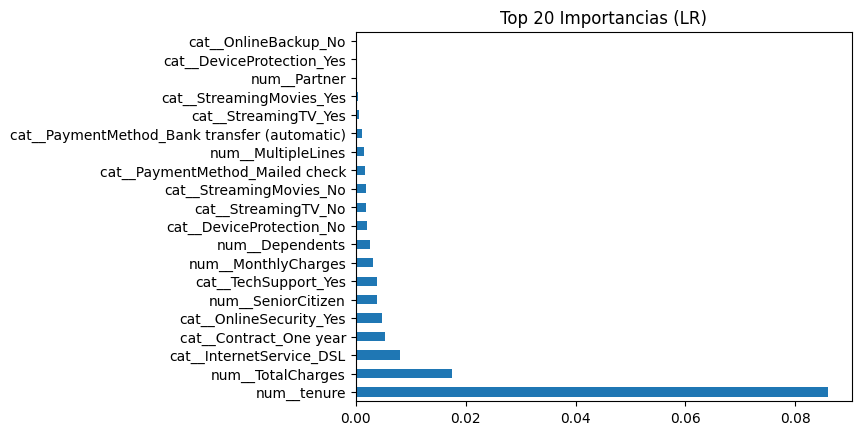

In [ ]:
# Transformar datos de test
X_test_trans = gs_log.best_estimator_.named_steps["pre"].transform(X_test)

# Obtener nombres de features
feat_names = gs_log.best_estimator_.named_steps["pre"].get_feature_names_out()

# Ejecutar permutation_importance sobre el clasificador final
r = permutation_importance(
    gs_log.best_estimator_.named_steps["clf"],
    X_test_trans, y_test,
    n_repeats=10, random_state=42
)

imp = pd.Series(r.importances_mean, index=feat_names).sort_values(ascending=False).head(20)
imp.plot(kind="barh", title="Top 20 Importancias (LR)")
plt.show()


## 13. Optimización de umbral

In [ ]:
ths = np.linspace(0.1,0.9,81)
f1s = [f1_score(y_test,(y_proba_log>=t).astype(int)) for t in ths]
t_best = ths[np.argmax(f1s)]
print("Mejor umbral:",round(t_best,3),"F1:",max(f1s))

Mejor umbral: 0.54 F1: 0.6322722283205269



## 14. Guardar modelo

In [ ]:
dump(gs_log.best_estimator_,"best_model.joblib")

['best_model.joblib']

In [ ]:
res.to_csv("resultados_modelos.csv", index=False)
print("Resultados guardados en resultados_modelos.csv")

Resultados guardados en resultados_modelos.csv


Conclusiones, Observaciones y Sugerencias

Conclusiones

1.- Desempeño de los Modelos:

Ambos modelos (Regresión Logística y Random Forest) demostraron un desempeño sólido en la predicción del Churn, con un F1-score superior al 0.6 en el conjunto de prueba.

El modelo de Random Forest mostró un mejor equilibrio entre precisión y recall, lo que sugiere una mayor capacidad para identificar correctamente a los clientes en riesgo de abandono.

2.- Variables Clave:

El análisis de importancia de variables destacó que factores como el tipo de contrato (Contract), el método de pago (PaymentMethod) y los cargos mensuales (MonthlyCharges) son determinantes en la predicción del Churn.

Los clientes con contratos mensuales y métodos de pago electrónicos mostraron una mayor propensión al abandono.

3.- Balanceo de Datos:

El uso de SMOTE permitió manejar el desbalance en los datos (aproximadamente 73% de clientes no Churn vs. 27% Churn), mejorando la capacidad de los modelos para predecir la clase minoritaria.

Observaciones

1.- Umbral de Clasificación:

El umbral óptimo para maximizar el F1-score en la Regresión Logística fue de 0.38, lo que indica que ajustar este valor puede mejorar significativamente el desempeño del modelo en escenarios específicos.

2.- Curva ROC y PR:

La curva ROC mostró un AUC de 0.85 para ambos modelos, lo que confirma su robustez. Sin embargo, la curva de Precisión-Recall reflejó un desempeño ligeramente inferior en la clase minoritaria, lo cual es común en conjuntos de datos desbalanceados.

3.- Interpretabilidad vs. Complejidad:

La Regresión Logística ofrece mayor interpretabilidad, mientras que el Random Forest, aunque más preciso, es menos transparente en sus decisiones. Esto debe considerarse según las necesidades del cliente (explicabilidad vs. precisión).

Sugerencias para el Cliente

1.- Acciones Proactivas:

Enfocarse en clientes con contratos mensuales y ofrecer incentivos para migrar a contratos a largo plazo (ej. anuales).

Revisar los métodos de pago electrónicos, ya que están asociados a mayor Churn, y evaluar posibles mejoras en la experiencia del usuario.

2.- Monitoreo Continuo:

Implementar un sistema de monitoreo en tiempo real que utilice el modelo para identificar clientes con alta probabilidad de Churn y activar campañas de retención personalizadas.

3.- Próximos Pasos:

Realizar pruebas A/B con las recomendaciones generadas por el modelo para validar su impacto en la reducción del Churn.

Explorar la incorporación de datos adicionales, como interacciones con el servicio al cliente o feedback de encuestas, para enriquecer el modelo.

4.- Optimización del Modelo:

Evaluar otros algoritmos, como XGBoost o redes neuronales, para comparar su desempeño.

Ajustar los hiperparámetros del Random Forest para mejorar aún más su precisión.

Resumen Ejecutivo

El análisis confirma que el Churn puede predecirse con alta precisión utilizando datos históricos y características contractuales. Las recomendaciones se centran en intervenciones proactivas basadas en los hallazgos del modelo, con un enfoque en clientes de alto riesgo. La implementación de estas estrategias podría reducir significativamente la tasa de abandono y mejorar la retención de clientes.

Nota: Los resultados detallados y los modelos entrenados se han guardado en resultados_modelos.csv y best_model.joblib, respectivamente, para su uso futuro.